# План и структура ноутбука

В этом ноутбуке мы:

1) Загружаем конфиг и модули проекта (src/*).
2) Загружаем и подготавливаем данные: определяем числовые/категориальные признаки, делим на train/test.
3) Строим классические ML-пайплайны (RF, LGBM, LR), подбираем гиперпараметры и собираем стекинг.
4) Готовим данные для MLP (PyTorch): формируем DataLoader’ы, считаем class weight и определяем input_dim.
5) Обучаем несколько вариантов MLP и смотрим график функции потерь.
6) Оцениваем качество MLP на валидации (balanced_accuracy, F1, ROC AUC) с заданным порогом.
7) Формируем файл submission.csv на основе лучше всего показавшей себя модели (LGBM, prob of class 1).


In [1]:
import os
from config import LR, NUM_EPOCHS, RANDOM_STATE, TEST_PATH, TRAIN_PATH
from data_and_preprocessors.data import load_data
from data_and_preprocessors.preprocessors import build_transformer_for_tree, build_transformer_for_regression

from classic_ml.evaluate_pipes import evaluate_pipes
from classic_ml.pipeline import make_pipelines
from classic_ml.grid_search import grid_search
from classic_ml.staking import build_and_fit_stacking

from mlp.mlp_model import MLPClassifier
from mlp.train_mlp import train_all_mlps
from mlp.mlp_prepare_data import mlp_prepare_data
from mlp.mlp_pipeline import make_mlp_pipeline
from mlp.plot_mlp_training_loss import plot_mlp_training_loss
from mlp.evaluate_mlp import evaluate_mlps, evaluate_mlp

from shap_utils.classic import explain_classic_model_with_shap
from shap_utils.mlp import explain_mlp_model_with_shap

from sklearn.model_selection import train_test_split

PYTHONPATH: ./src


PYTHONPATH: ./src


d:\py\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Импорты и конфигурация

В этой секции подключаем:
- Константы из `config.py`: `LR`, `NUM_EPOCHS`, `RANDOM_STATE`, `TRAIN_PATH`, `TEST_PATH`.
- Функции загрузки данных и препроцессоров из `src/data_and_preprocessors/*`.
- Пайплайны, грид-сёрч, стекинг и оценку классических моделей из `src/classic_ml/*`.
- Компоненты для MLP (модель, подготовка данных, обучение, графики, метрики) из `src/mlp/*`.

Идея: все параметры и пути централизованы в конфиге, а логика — в модулях `src/`.


In [2]:
test_data, train_data, target_data, idx = load_data(TRAIN_PATH, TEST_PATH)

# Ограничиваем размер данных для ускорения тестов 
# test_data = test_data.iloc[:300, :]
# target_data = target_data.iloc[:300]
# train_data = train_data.iloc[:300, :]
# idx = idx.iloc[:300]

categorical_cols = test_data.select_dtypes(include=['object']).columns
numerical_cols = test_data.select_dtypes(exclude=['object']).columns.drop(['person_age', 'person_income'])

X_train, X_test, y_train, y_test = train_test_split(train_data, target_data, test_size=0.2, 
                                        random_state=RANDOM_STATE, stratify=target_data)

## Подготовка данных и разбиение

- `load_data(TRAIN_PATH, TEST_PATH)` возвращает раздельно признаки train/test, цель и индексы.
- Автоматически определяем типы признаков: `categorical_cols` и `numerical_cols`.
- Исключаем из числовых столбцов `person_age` и `person_income`, т.к. для них далее предусмотрена отдельная обработка.
- Делим данные на `X_train/X_test` и `y_train/y_test` со стратификацией по `RANDOM_STATE`.


In [3]:
pipelines = make_pipelines(numerical_cols.tolist(), categorical_cols.tolist(), random_state=RANDOM_STATE)
best_models = grid_search(pipelines, X_train, y_train, random_state=RANDOM_STATE)
stack = build_and_fit_stacking(best_models['rf'], best_models['lgbm'], X_train, y_train, random_state=RANDOM_STATE)

print("\nClassic ML models evaluation:")
evaluate_pipes(best_models, X_test, y_test,)
print("\nStacking evaluation:")
evaluate_pipes({'stacking': stack}, X_test, y_test)

RF best: {'clf__max_depth': 20, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
LR best: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
LR best: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


RF best: {'clf__max_depth': 20, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
LR best: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
LR best: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


d:\py\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RF best: {'clf__max_depth': 20, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
LR best: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
LR best: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


d:\py\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Info] Number of positive: 6490, number of negative: 40122
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 850
[LightGBM] [Info] Number of data points in the train set: 46612, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LGBM best: {'clf__num_leaves': 31, 'clf__n_estimators': 100, 'clf__learning_rate': 0.1}
LGBM best: {'clf__num_leaves': 31, 'clf__n_estimators': 100, 'clf__learning_rate': 0.1}

Classic ML models evaluation:

Classic ML models evaluation:
--- rf ---
balanced_accuracy: 0.845641172600498
f1_macro: 0.8843734626277383
roc_auc_macro: 0.9341302033517439

--- lr ---
balanced_accuracy: 0.8360550511128353
f1_macro: 0.7487118785947287
roc_auc_macro: 0.9047919396462493

--- lgbm ---
balanced_accuracy: 0.8878744849861

RF best: {'clf__max_depth': 20, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
LR best: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
LR best: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


d:\py\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Info] Number of positive: 6490, number of negative: 40122
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 850
[LightGBM] [Info] Number of data points in the train set: 46612, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LGBM best: {'clf__num_leaves': 31, 'clf__n_estimators': 100, 'clf__learning_rate': 0.1}
LGBM best: {'clf__num_leaves': 31, 'clf__n_estimators': 100, 'clf__learning_rate': 0.1}

Classic ML models evaluation:

Classic ML models evaluation:
--- rf ---
balanced_accuracy: 0.845641172600498
f1_macro: 0.8843734626277383
roc_auc_macro: 0.9341302033517439

--- lr ---
balanced_accuracy: 0.8360550511128353
f1_macro: 0.7487118785947287
roc_auc_macro: 0.9047919396462493

--- lgbm ---
balanced_accuracy: 0.8878744849861

d:\py\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\py\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\py\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\py\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


RF best: {'clf__max_depth': 20, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
LR best: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
LR best: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


d:\py\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Info] Number of positive: 6490, number of negative: 40122
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 850
[LightGBM] [Info] Number of data points in the train set: 46612, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LGBM best: {'clf__num_leaves': 31, 'clf__n_estimators': 100, 'clf__learning_rate': 0.1}
LGBM best: {'clf__num_leaves': 31, 'clf__n_estimators': 100, 'clf__learning_rate': 0.1}

Classic ML models evaluation:

Classic ML models evaluation:
--- rf ---
balanced_accuracy: 0.845641172600498
f1_macro: 0.8843734626277383
roc_auc_macro: 0.9341302033517439

--- lr ---
balanced_accuracy: 0.8360550511128353
f1_macro: 0.7487118785947287
roc_auc_macro: 0.9047919396462493

--- lgbm ---
balanced_accuracy: 0.8878744849861

d:\py\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\py\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\py\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\py\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


--- stacking ---
balanced_accuracy: 0.8870209765036375
f1_macro: 0.839344646911675
roc_auc_macro: 0.9567293805582635



d:\py\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Классические модели: обучение, подбор, стекинг (случайный лес, бустинг, регрессия)

- `make_pipelines(...)` собирает пайплайны с нужными препроцессорами под деревья/линейные модели.
- `grid_search(...)` подбирает гиперпараметры и возвращает лучшие экземпляры моделей (например, `rf`, `lgbm`).
- `build_and_fit_stacking(...)` строит стекинг из лучших базовых моделей с логистической регрессией в качестве мета-оценщика.
- `evaluate_pipes(...)` считает метрики на валидационном сете: balanced_accuracy, F1 (macro), ROC AUC (для бинарной задачи — по вероятности класса 1).


## Подготовка данных для MLP

- `mlp_prepare_data(...)` применяет числовые/категориальные трансформации, формирует тензоры и возвращает:
  - `train_loader`, `test_loader` — DataLoader’ы PyTorch;
  - `weight` — class weight для `BCEWithLogitsLoss` (борьба с дисбалансом);
  - `input_dim` — размерность признакового пространства для входного слоя MLP (исправляет возможные несоответствия размеров).
- `make_mlp_pipeline(input_dim)` строит набор архитектур MLP, совместимых с полученным `input_dim`.


In [4]:
train_loader, test_loader, weight, input_dim = mlp_prepare_data(X_train, X_test, y_train, y_test, numerical_cols, categorical_cols)
mlp_pipe = make_mlp_pipeline(input_dim)

## Обучение MLP и мониторинг

- `train_all_mlps(mlp_pipe, train_loader, weight, n_epochs=NUM_EPOCHS, lr=LR)` обучает все варианты MLP; используется `BCEWithLogitsLoss(pos_weight=weight)` и планировщик шага.
- `plot_mlp_training_loss(mlp_pipe, test_loader)` визуализирует динамику функции потерь.

Примечание: финальный слой модели возвращает логиты; пороги применяются на этапе оценки.


Training model: large
Epoch [5/25], Loss: 0.6715
Epoch [5/25], Loss: 0.6715
Epoch [10/25], Loss: 0.6523
Epoch [10/25], Loss: 0.6523
Epoch [15/25], Loss: 0.6434
Epoch [15/25], Loss: 0.6434
Epoch [20/25], Loss: 0.6380
Epoch [20/25], Loss: 0.6380
Epoch [25/25], Loss: 0.6328
Training model: medium
Epoch [25/25], Loss: 0.6328
Training model: medium
Epoch [5/25], Loss: 0.7244
Epoch [5/25], Loss: 0.7244
Epoch [10/25], Loss: 0.7009
Epoch [10/25], Loss: 0.7009
Epoch [15/25], Loss: 0.6887
Epoch [15/25], Loss: 0.6887
Epoch [20/25], Loss: 0.6843
Epoch [20/25], Loss: 0.6843
Epoch [25/25], Loss: 0.6834
Training model: small
Epoch [25/25], Loss: 0.6834
Training model: small
Epoch [5/25], Loss: 0.8101
Epoch [5/25], Loss: 0.8101
Epoch [10/25], Loss: 0.7879
Epoch [10/25], Loss: 0.7879
Epoch [15/25], Loss: 0.7866
Epoch [15/25], Loss: 0.7866
Epoch [20/25], Loss: 0.7804
Epoch [20/25], Loss: 0.7804
Epoch [25/25], Loss: 0.7832
Training model: deep
Epoch [25/25], Loss: 0.7832
Training model: deep
Epoch [5/25]

Training model: large
Epoch [5/25], Loss: 0.6715
Epoch [5/25], Loss: 0.6715
Epoch [10/25], Loss: 0.6523
Epoch [10/25], Loss: 0.6523
Epoch [15/25], Loss: 0.6434
Epoch [15/25], Loss: 0.6434
Epoch [20/25], Loss: 0.6380
Epoch [20/25], Loss: 0.6380
Epoch [25/25], Loss: 0.6328
Training model: medium
Epoch [25/25], Loss: 0.6328
Training model: medium
Epoch [5/25], Loss: 0.7244
Epoch [5/25], Loss: 0.7244
Epoch [10/25], Loss: 0.7009
Epoch [10/25], Loss: 0.7009
Epoch [15/25], Loss: 0.6887
Epoch [15/25], Loss: 0.6887
Epoch [20/25], Loss: 0.6843
Epoch [20/25], Loss: 0.6843
Epoch [25/25], Loss: 0.6834
Training model: small
Epoch [25/25], Loss: 0.6834
Training model: small
Epoch [5/25], Loss: 0.8101
Epoch [5/25], Loss: 0.8101
Epoch [10/25], Loss: 0.7879
Epoch [10/25], Loss: 0.7879
Epoch [15/25], Loss: 0.7866
Epoch [15/25], Loss: 0.7866
Epoch [20/25], Loss: 0.7804
Epoch [20/25], Loss: 0.7804
Epoch [25/25], Loss: 0.7832
Training model: deep
Epoch [25/25], Loss: 0.7832
Training model: deep
Epoch [5/25]

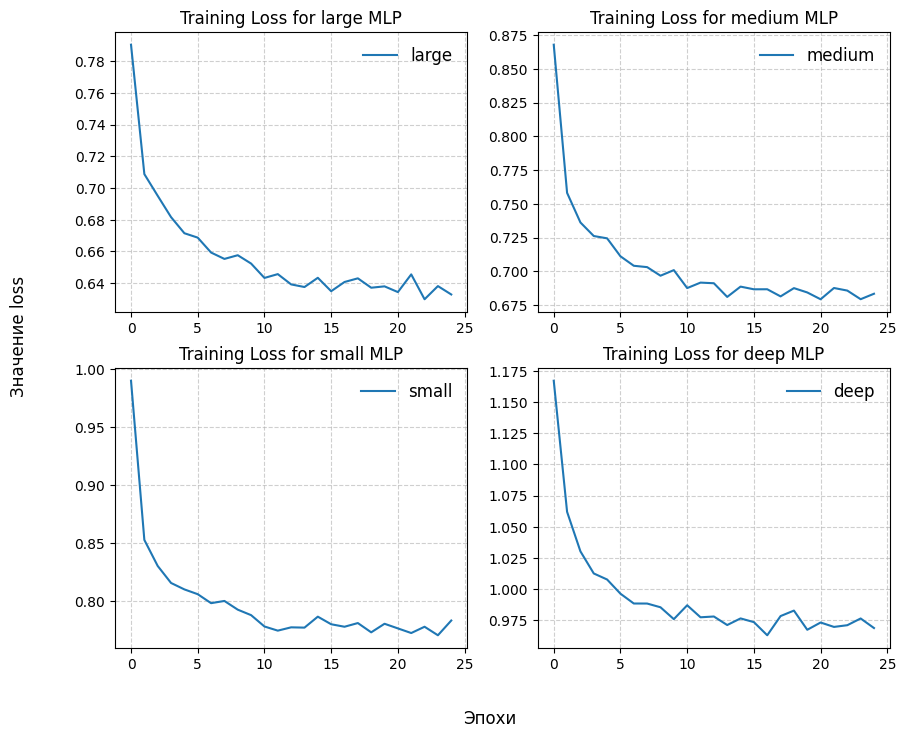

In [5]:
train_loss = train_all_mlps(mlp_pipe, train_loader, weight, n_epochs=NUM_EPOCHS, lr=LR)
plot_mlp_training_loss(mlp_pipe, train_loss) # 

## Оценка MLP на валидации

- Для каждого варианта MLP считаем метрики: balanced_accuracy, F1 (macro), ROC AUC.
- Порог классификации задаётся параметром `threshold` (по умолчанию 0.7 в данном ноутбуке).
- Внутри `evaluate_mlp` логиты преобразуются в вероятности сигмоидой, а затем порогуются.


In [6]:
for model_name, model in mlp_pipe.items():
    evaluate_mlp(model, test_loader, threshold=0.7)


balanced_accuracy: 0.8481
f1_macro: 0.8563
roc_auc: 0.929568226927351

balanced_accuracy: 0.8457
f1_macro: 0.8541
roc_auc: 0.9281357099373475

balanced_accuracy: 0.8457
f1_macro: 0.8541
roc_auc: 0.9281357099373475

balanced_accuracy: 0.847
f1_macro: 0.8366
roc_auc: 0.9243065013216666

balanced_accuracy: 0.847
f1_macro: 0.8366
roc_auc: 0.9243065013216666

balanced_accuracy: 0.8132
f1_macro: 0.8572
roc_auc: 0.8713847981625057

balanced_accuracy: 0.8132
f1_macro: 0.8572
roc_auc: 0.8713847981625057



# SHAPE

SHAP for rf:


SHAP for rf:


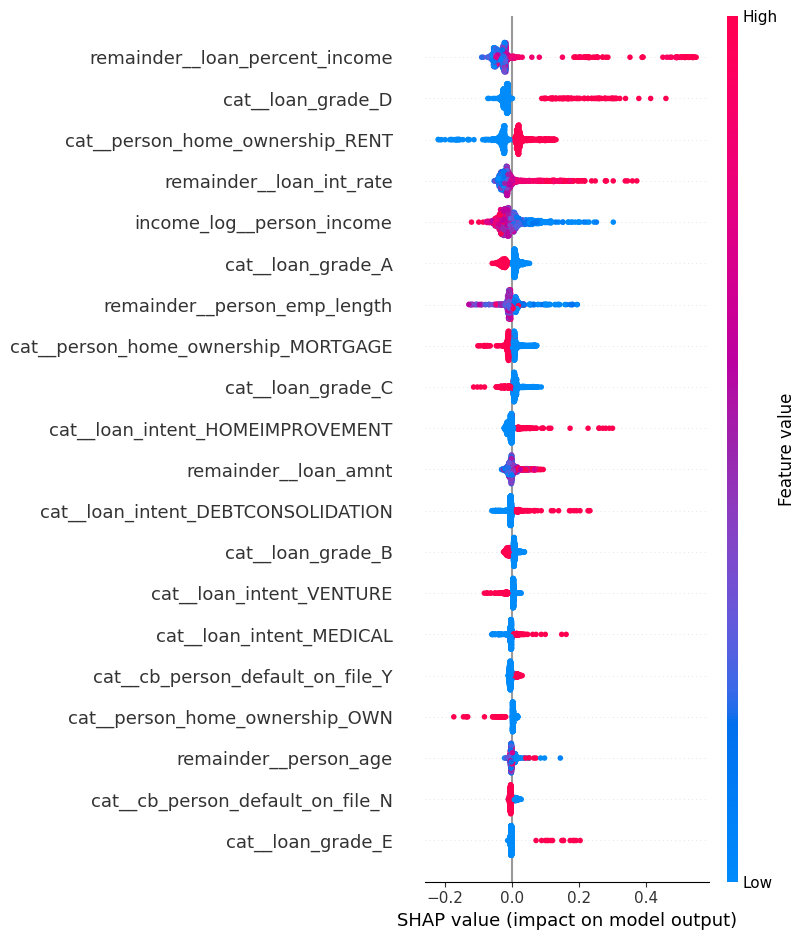

SHAP for rf:


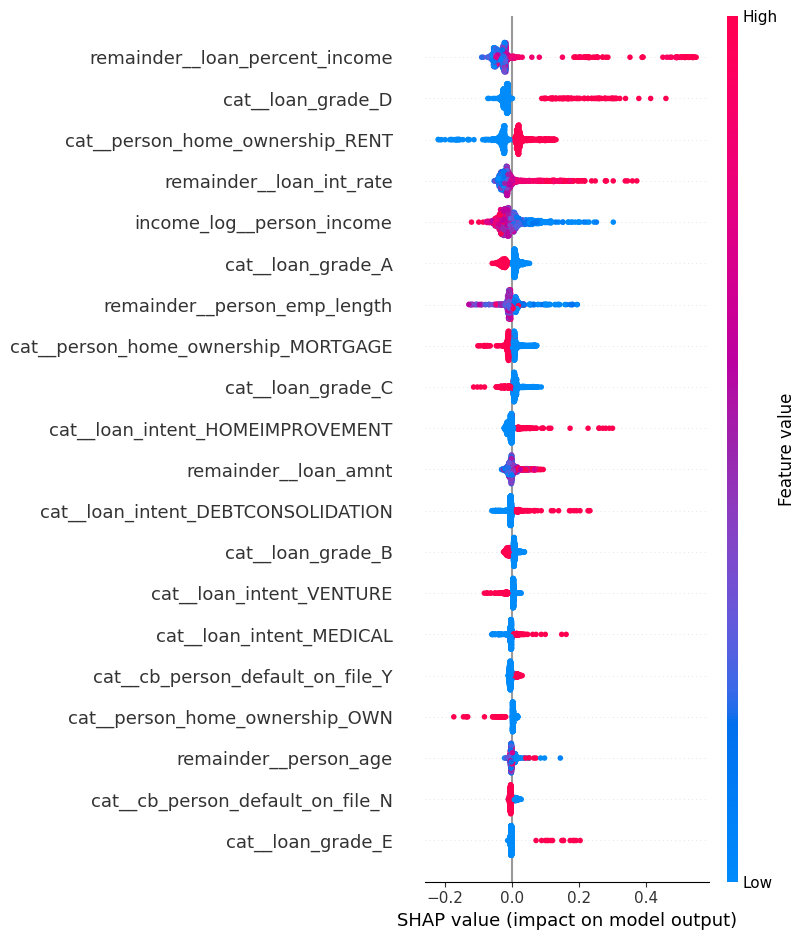

SHAP for lr:


SHAP for rf:


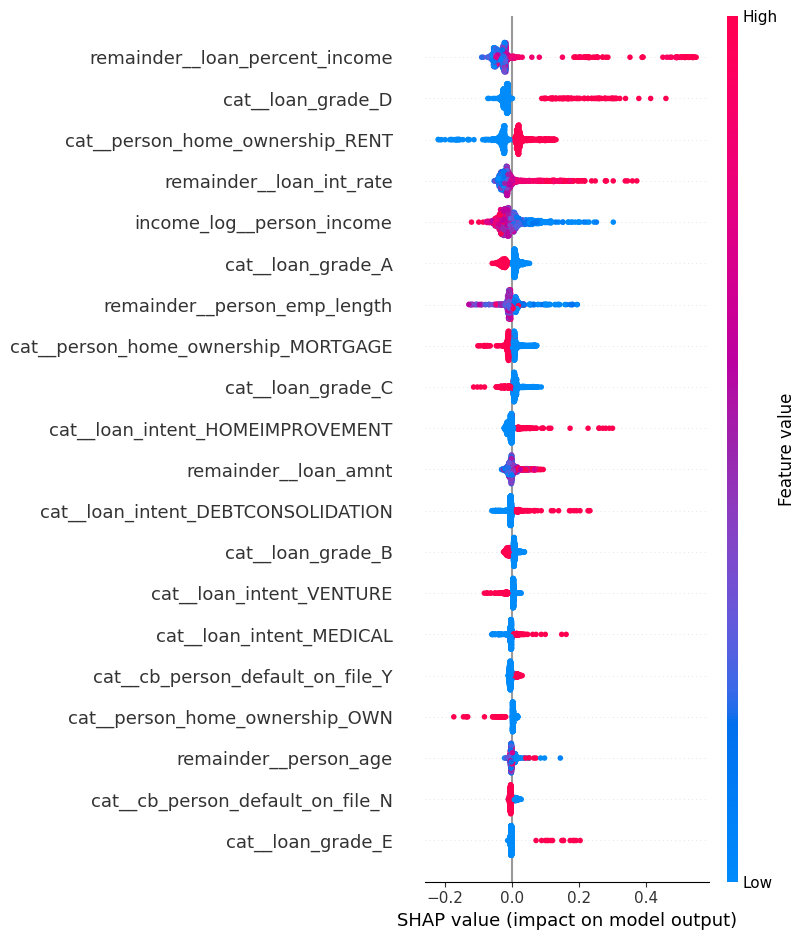

SHAP for lr:


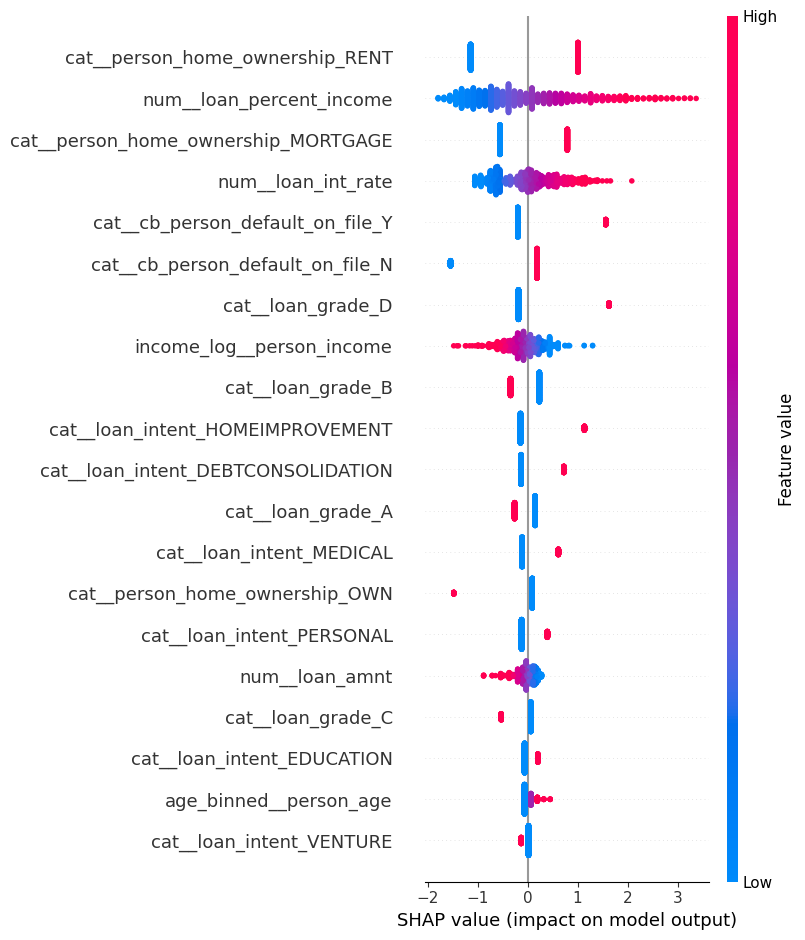

SHAP for rf:


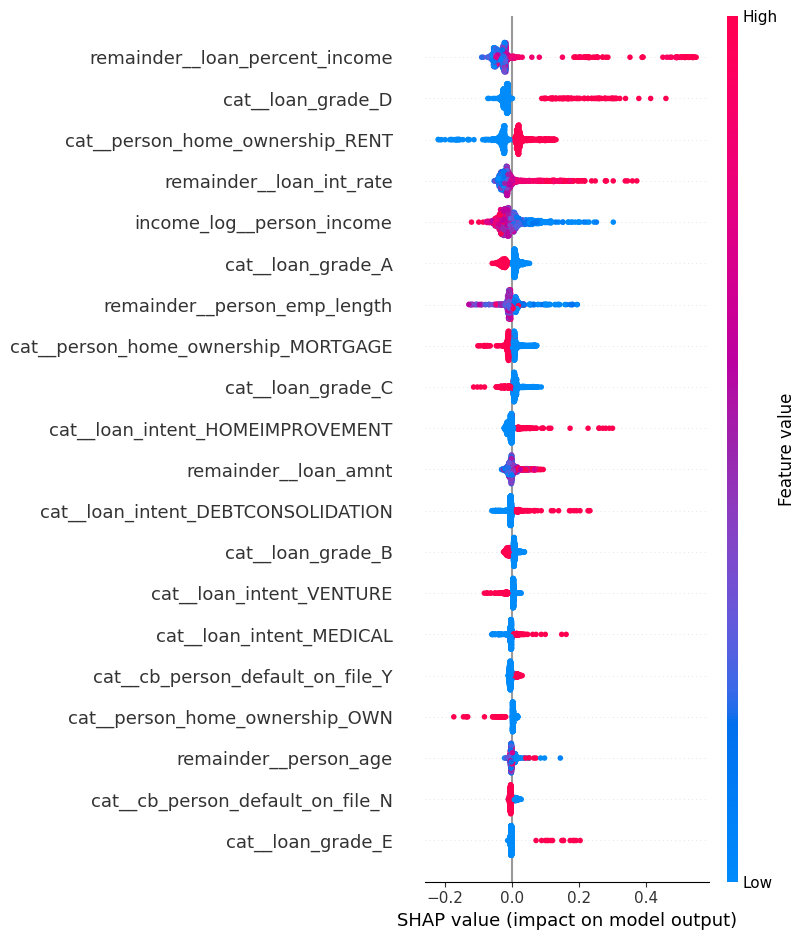

SHAP for lr:


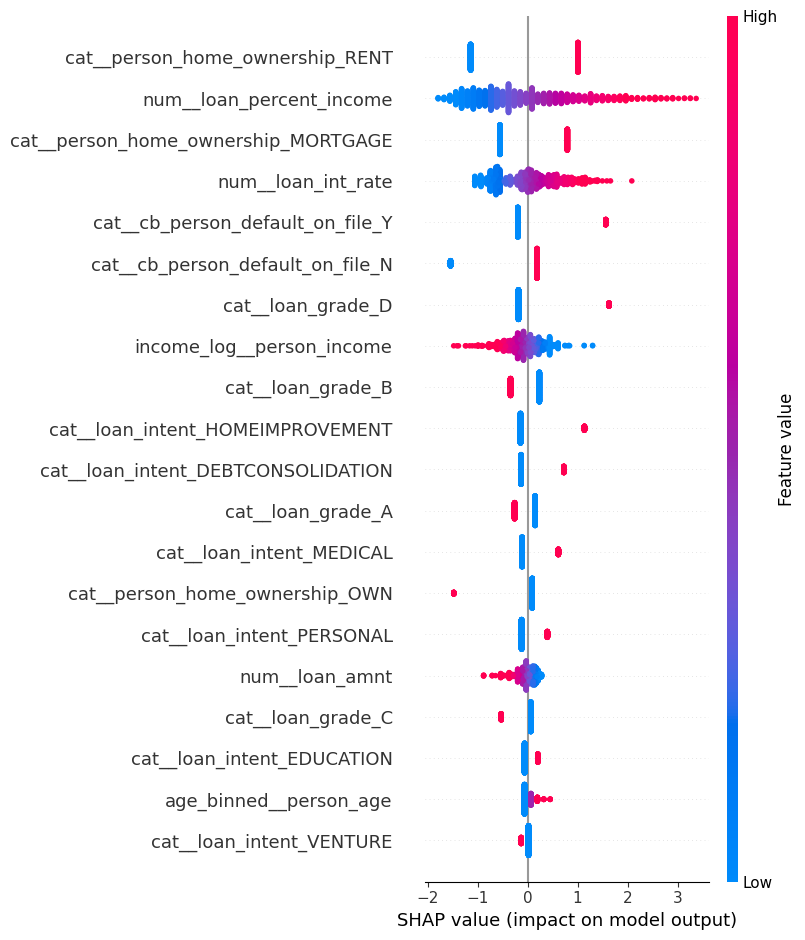

SHAP for lgbm:


SHAP for rf:


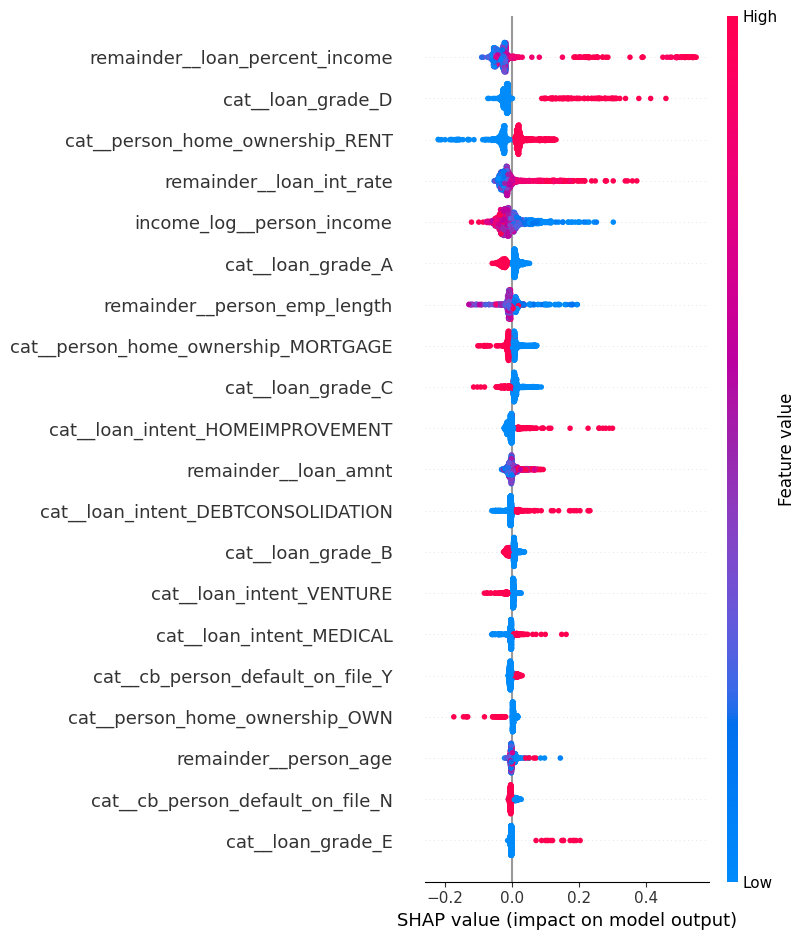

SHAP for lr:


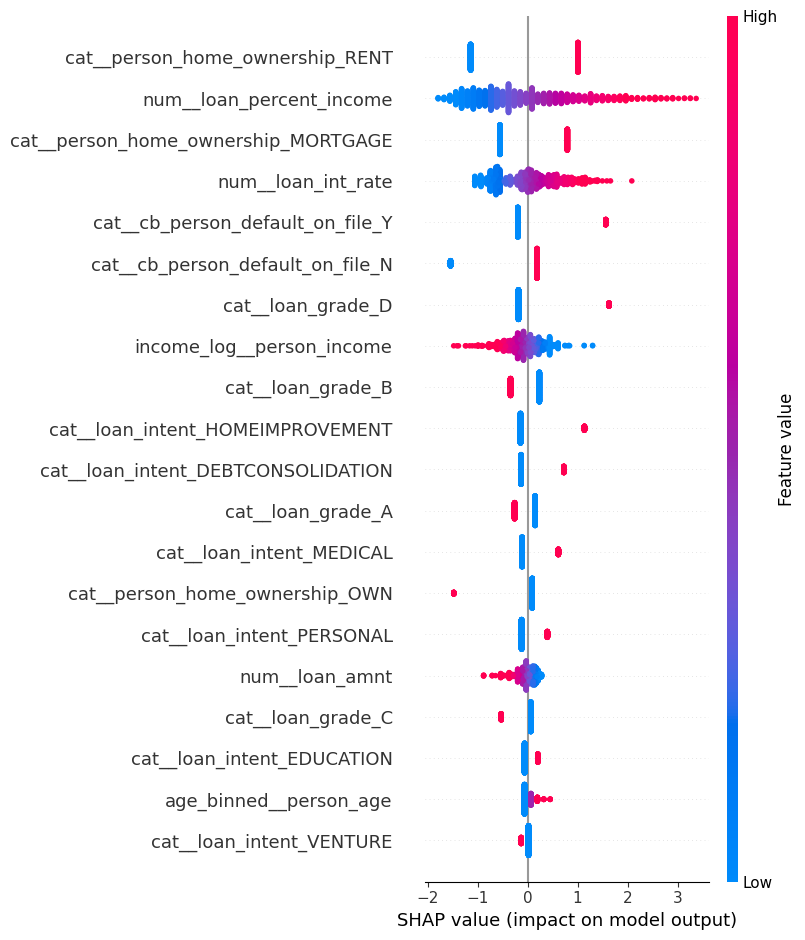

SHAP for lgbm:


d:\py\Lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


SHAP for rf:


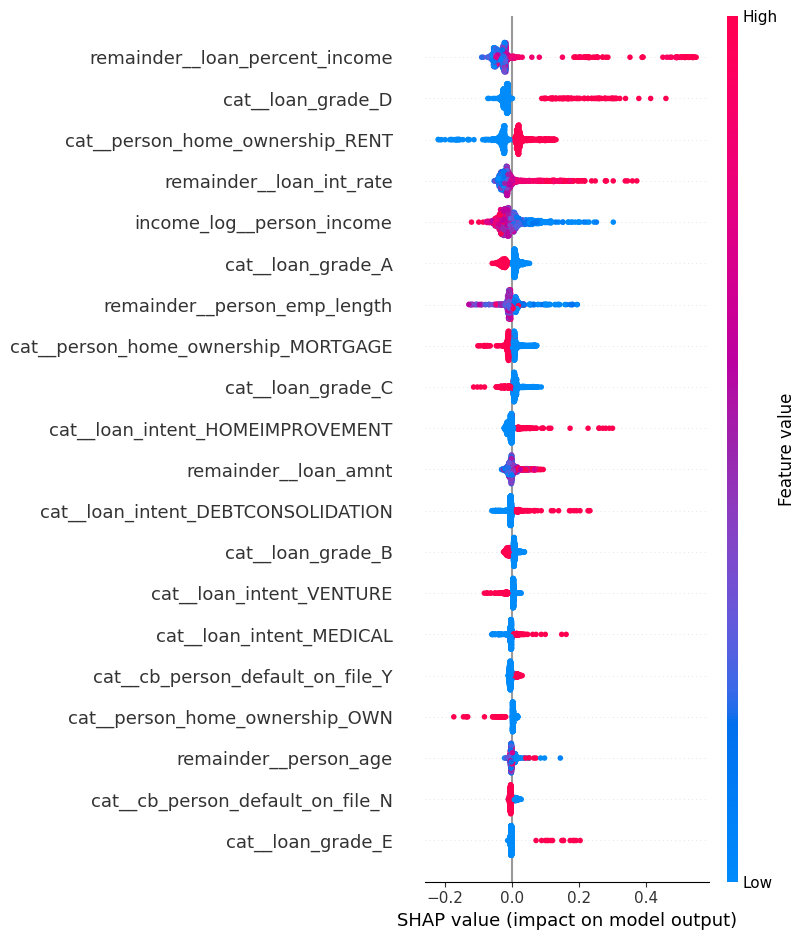

SHAP for lr:


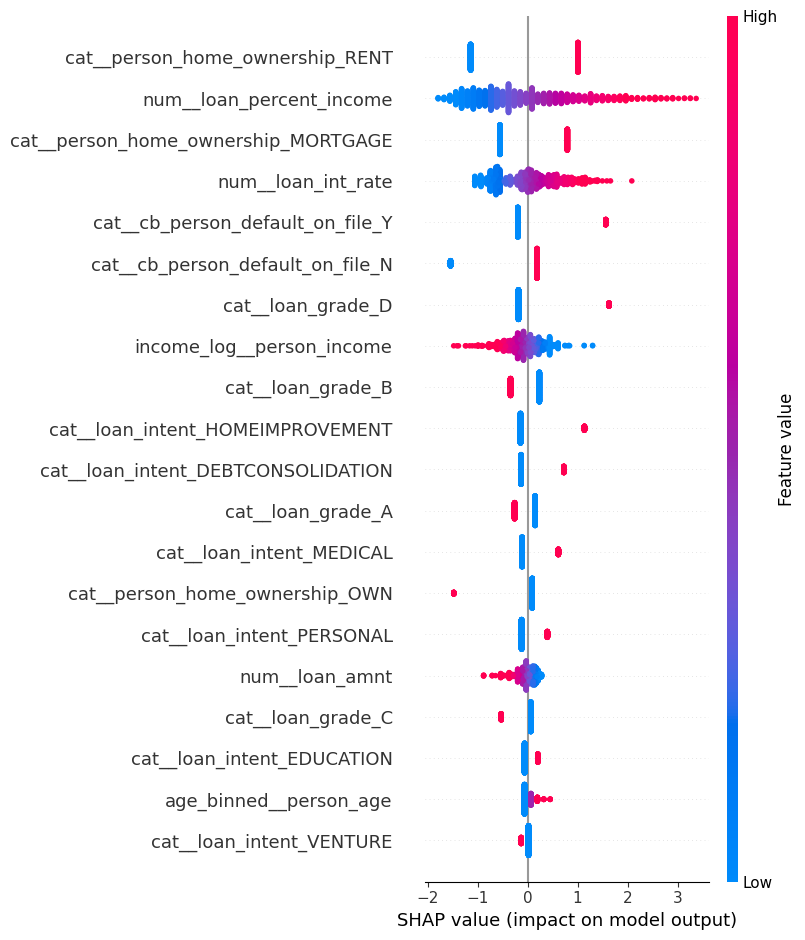

SHAP for lgbm:


d:\py\Lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


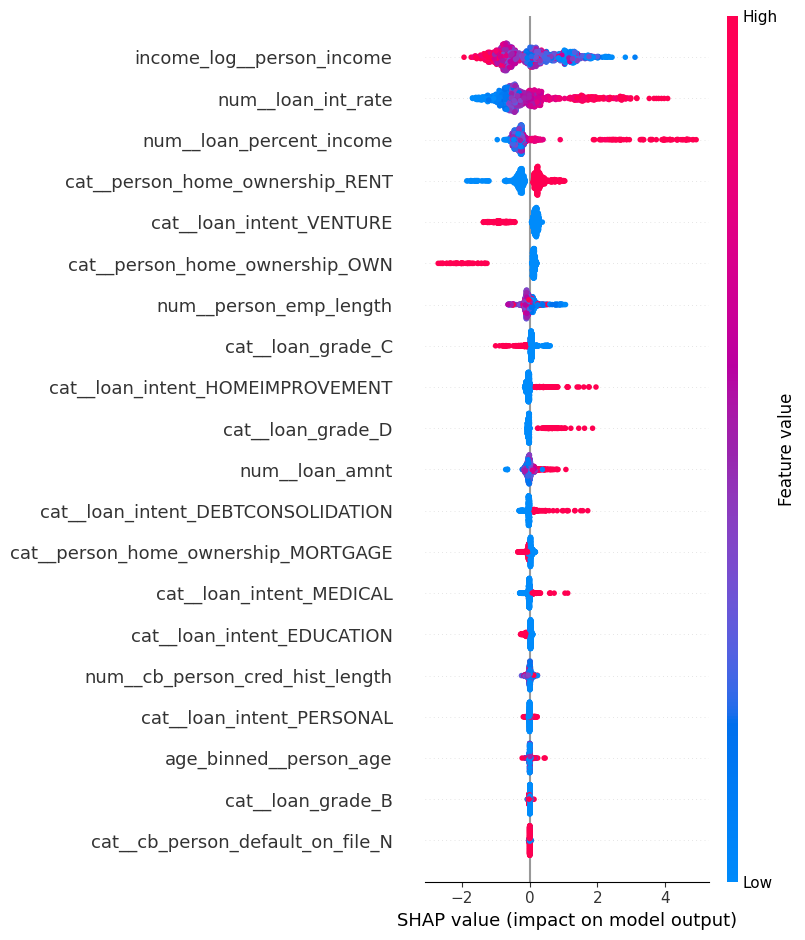

In [7]:
X_test_sample = X_test.sample(n=1000, random_state=42)
for model_name, model in best_models.items():
    print(f"SHAP for {model_name}:")
    explain_classic_model_with_shap(model, X_test_sample)

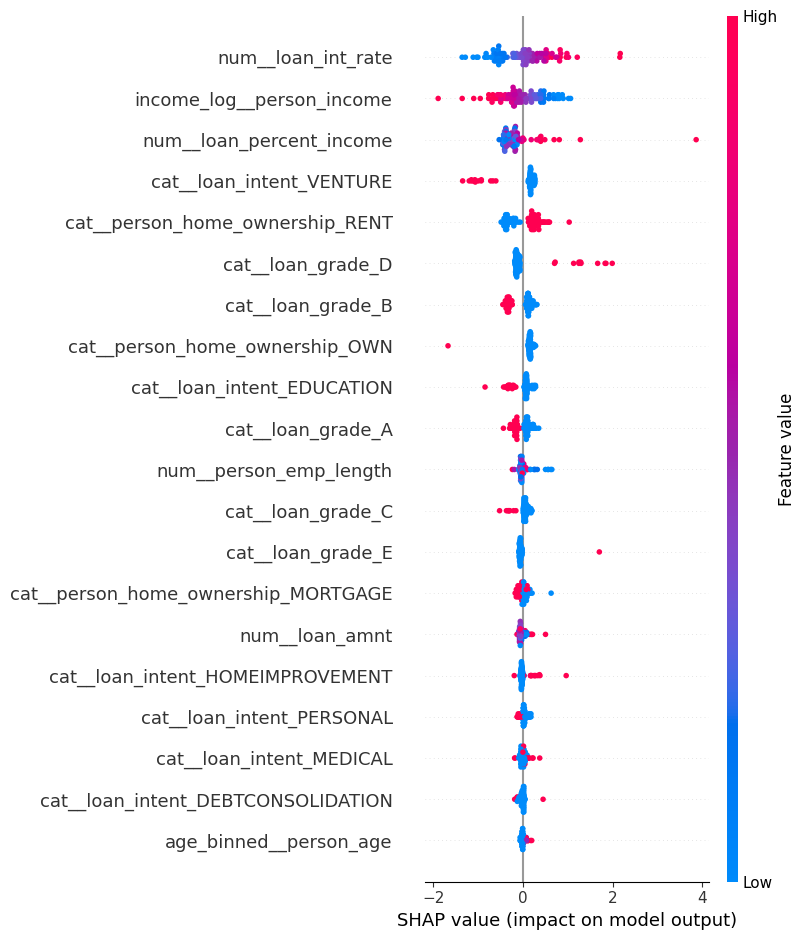

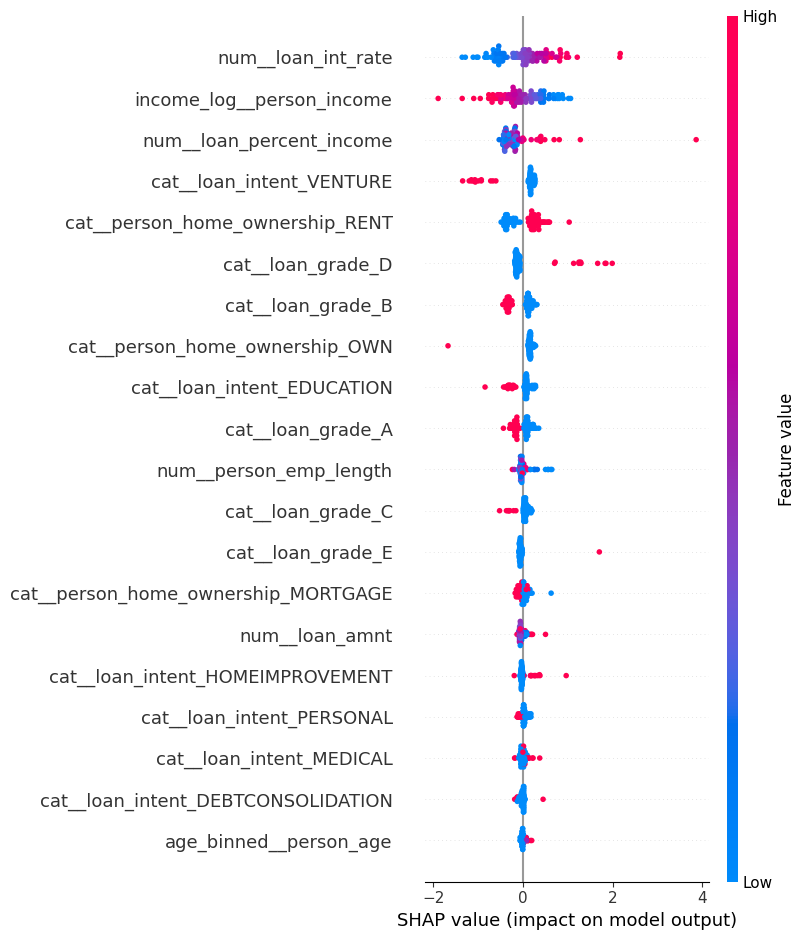

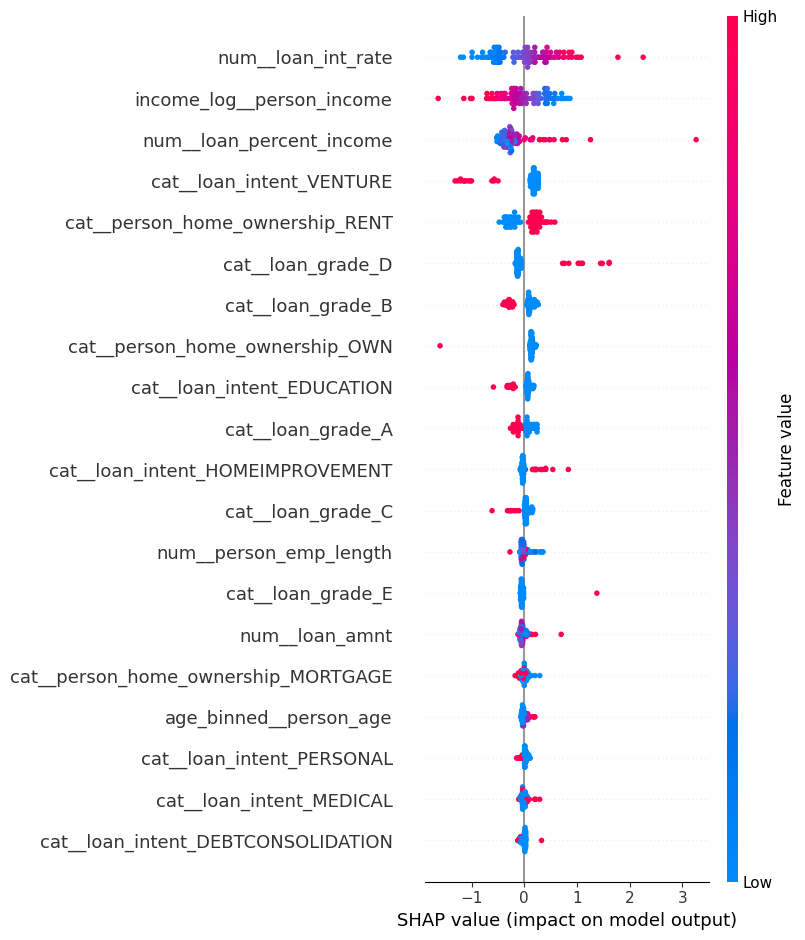

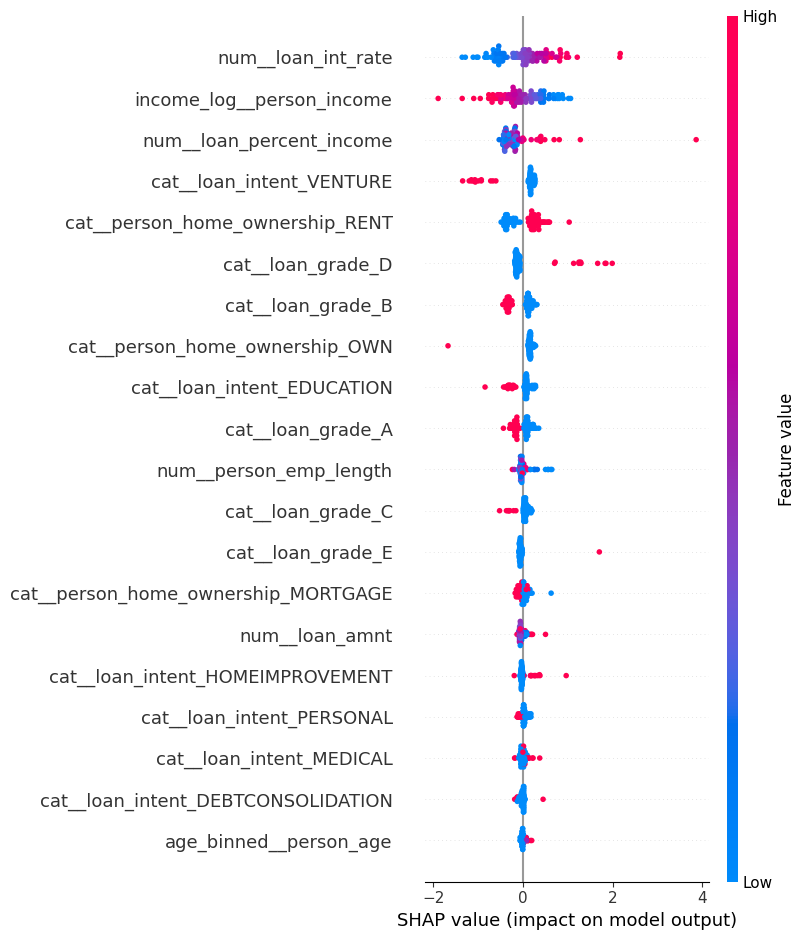

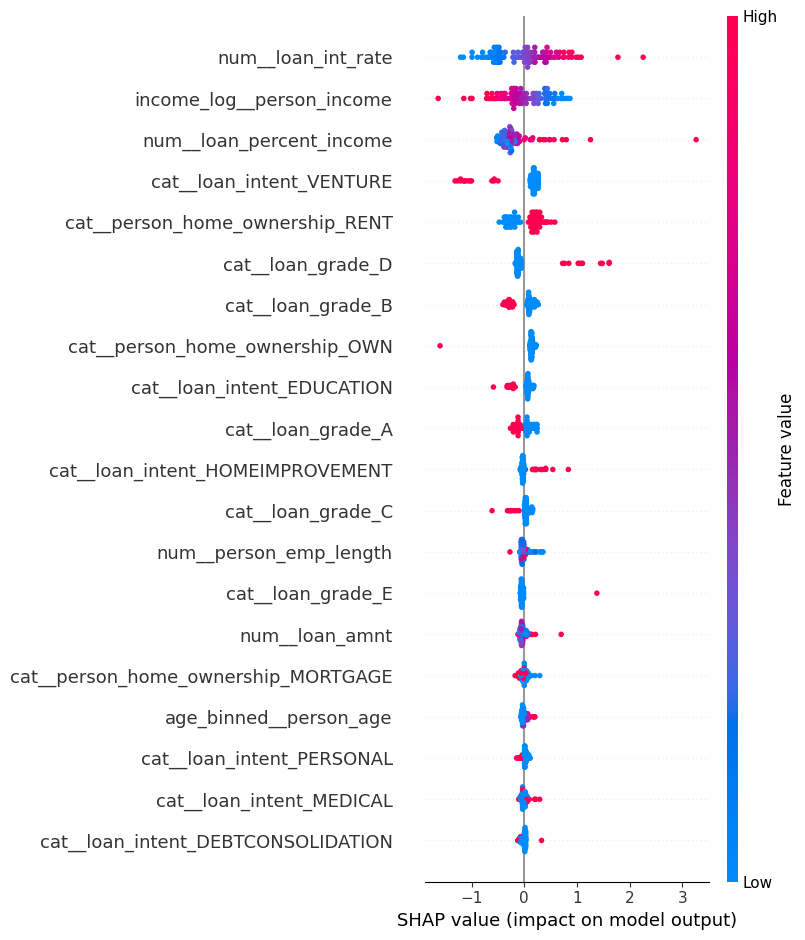

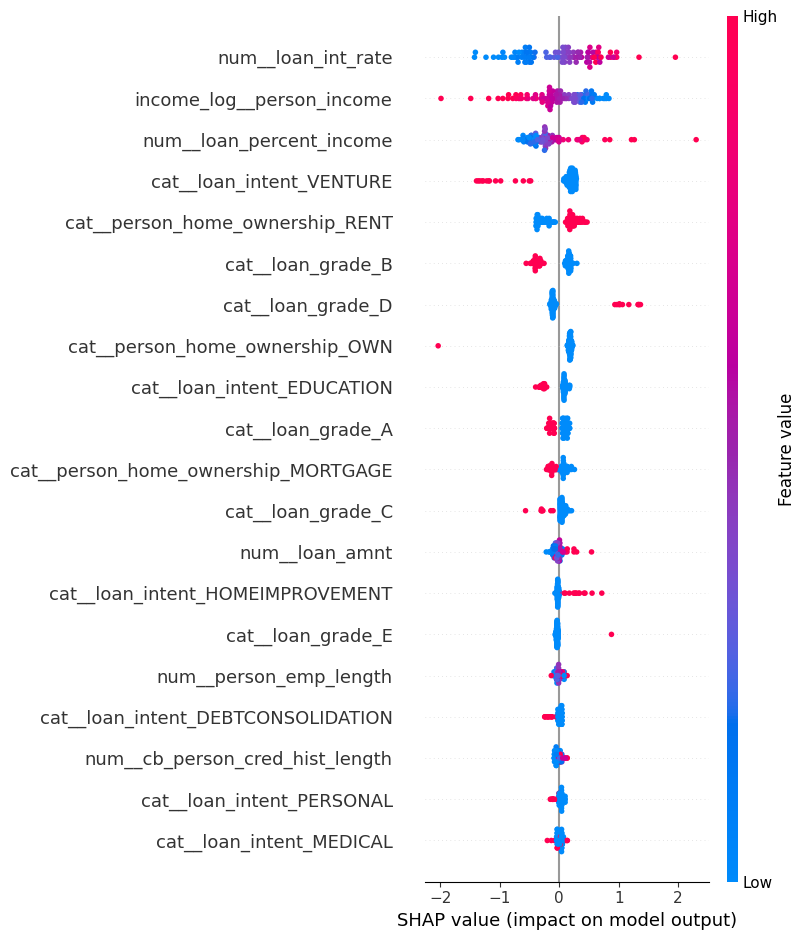

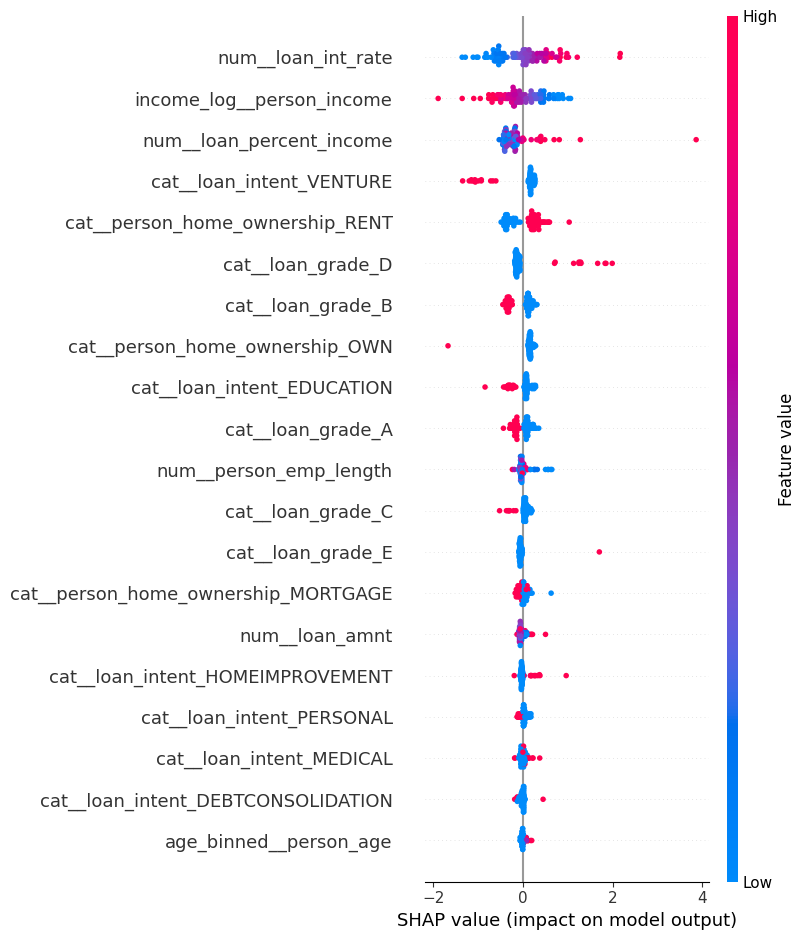

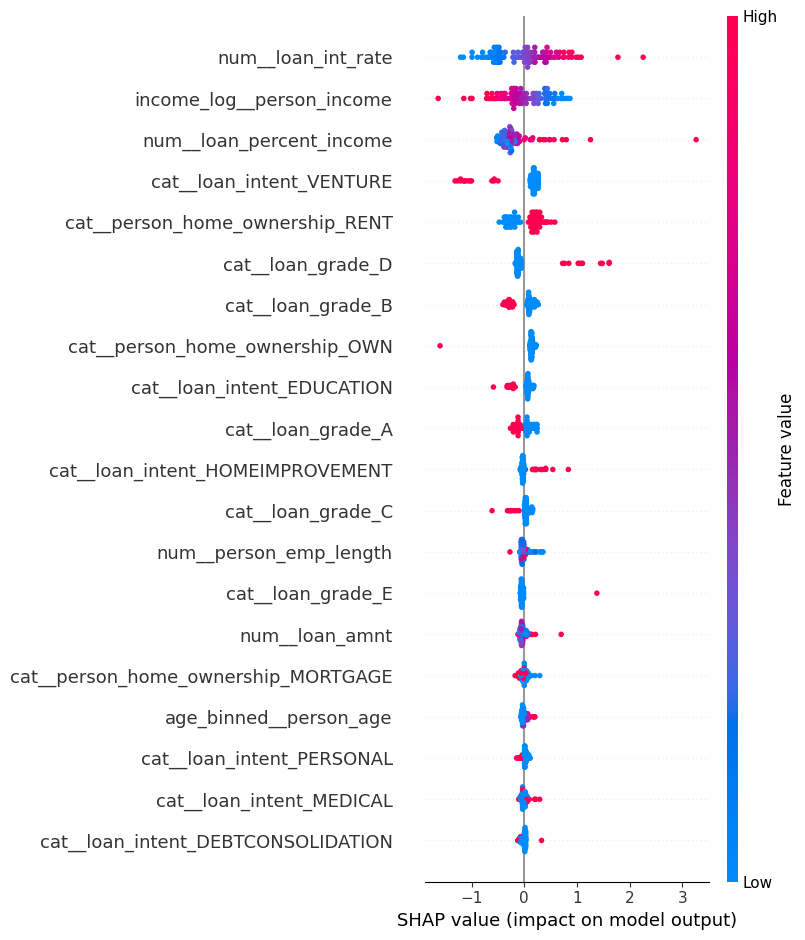

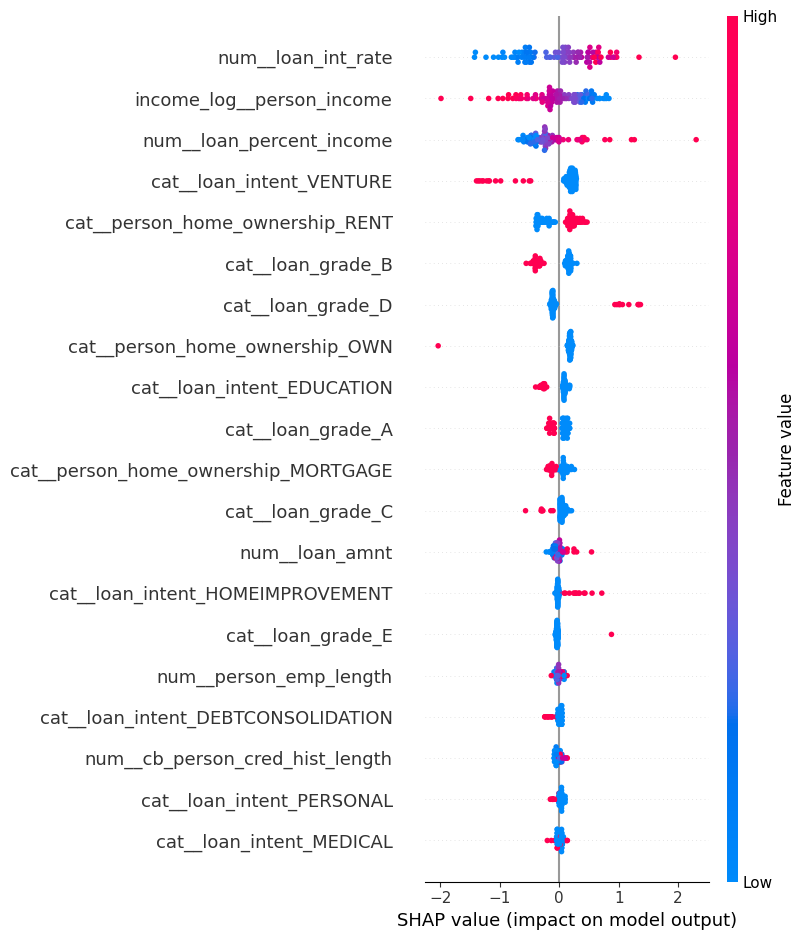

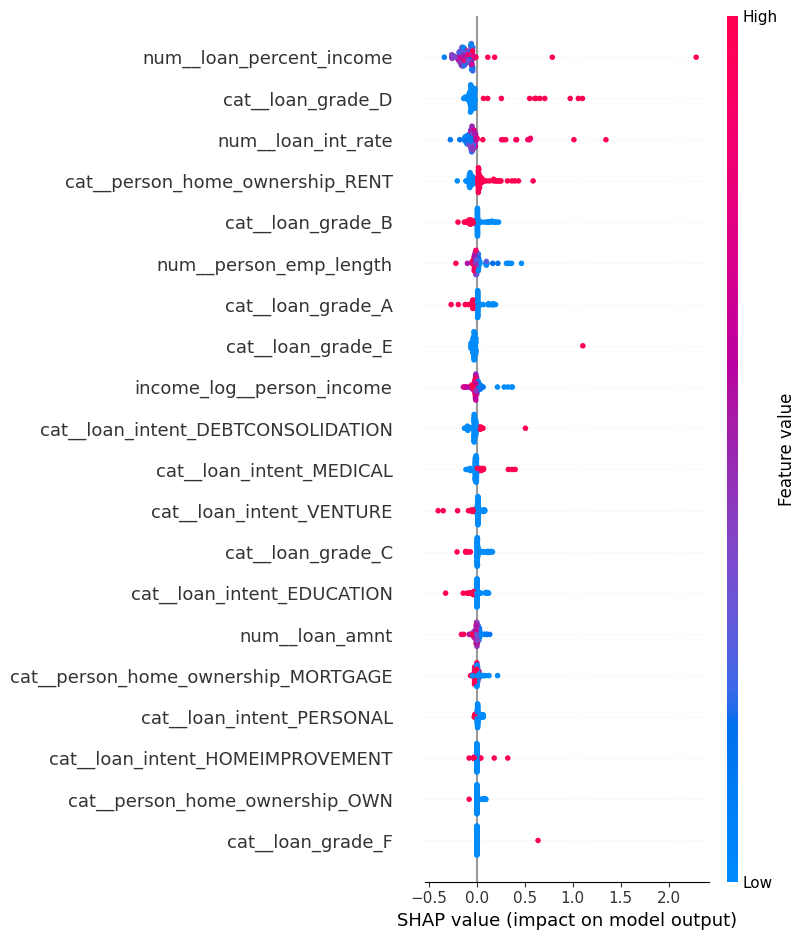

In [8]:
for model_name, model in mlp_pipe.items():
    explain_mlp_model_with_shap(model, X_train, X_test, numerical_cols, categorical_cols, n_samples=100)

## Формирование submission

- Используем лучшую классическую модель (здесь — `best_models['lgbm']`) и берём вероятность класса 1: `predict_proba(... )[:, 1]`.
- Формируем DataFrame с `id` и `loan_status`, сохраняем в `submission.csv`.
- Файл пригоден для отправки на соревнование/валидационный сервис.


In [9]:
import pandas as pd
ans = pd.DataFrame({'id': idx})
ans['loan_status'] = best_models['lgbm'].predict_proba(test_data)[:, 1]
ans.to_csv('submission.csv', index=False)

d:\py\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Выводы SHAP по моделям
1. LightGBM / Random Forest
Хорошо улавливают нелинейные пороги: например, loan_percent_income начинает резко «портить» скор только после определённого уровня.
На summary plot видны «пучки» точек: при низких значениях признака влияние почти нулевое, после порога — резкий рост SHAP.

2. Logistic Regression
Картина более «линейная»: чем больше признак, тем более однонаправленно сдвигается SHAP.
Хорошо, чтобы видеть базовые, легко интерпретируемые эффекты, но заметно проигрывает деревьям в улавливании сложных комбинаций.

3. MLP (PyTorch)
Повторяет общую логику деревьев: основные признаки те же (loan_percent_income, person_income, история дефолта).
Облака точек более «размазаны»: нейросеть выучивает комбинации признаков, поэтому нет таких чётких порогов, как у LGBM.
При этом ranking признаков (по важности) у MLP и LightGBM в целом согласован — это хороший знак.


## Бизнес‑выводы по SHAP

На основе SHAP‑анализa можно сформулировать интерпретируемые правила для принятия решений:

1. Заёмщики с **высокой нагрузкой по кредиту** (`loan_percent_income`), **низким доходом** (`person_income`),
   **высокой процентной ставкой** (`loan_int_rate`) и **дефолтами в прошлом** (`cb_person_default_on_file = Y`)
   практически всегда попадают в зону повышенного риска (SHAP > 0).

2. Клиенты с **умеренной долей займа к доходу**, **стабильным/высоким доходом** и **чистой кредитной историей**
   формируют область, где модель уверенно склоняется к одобрению кредита (SHAP < 0).

3. Социально‑демографические признаки (возраст, тип владения жильём и др.) влияют на решение, но их вклад
   значительно меньше, чем у признаков, связанных с платёжеспособностью и историей дефолтов.

Такие выводы можно использовать для:
- уточнения кредитной политики (порог по `loan_percent_income`, минимальный уровень дохода и т.п.);
- объяснения решений модели бизнес‑пользователям и регуляторам;
- поиска кандидатов для добавления новых признаков (например, детализация структуры дохода или долговой нагрузки).